In [1]:
%load_ext autoreload

In [2]:
import os
import math
import random

import wandb
import numpy as np

import torch
from torch import nn
from torch import distributions

import matplotlib.pyplot as plt

from tqdm.auto import tqdm, trange


In [3]:
%autoreload 2
import utils
from model import SimpleNet, ModelOutput
from samplers import VPSDE, DDPM, losses
from buffers import ReplayBuffer, LangevinReplayBuffer
from datasets_2d import registry, DatasetSampler

In [4]:
def seed_everython(seed=3407):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

seed_everython(3407)

In [5]:
def extract_into_tensor(tensor, shape):
    num_expand_dims = len(shape) - 1
    return tensor.view([-1] + [1 for _ in range(num_expand_dims)])


def rotate_mean(mean, angle=torch.pi / 4):
    cos = math.cos(angle)
    sin = math.sin(angle)
    R = torch.tensor([
        [cos, -sin],
        [sin,  cos]
    ], device=mean.device)
    return (R @ mean.T).T


def scatter(tensor):
    plt.scatter(tensor[:, 0], tensor[:, 1])
    

def plot_trajectory(trajectory, labels: list[str] | None = None, 
                    indices: None | list = None, title: str | None = None):
    if indices is not None:
        trajectory = [trajectory[i] for i in indices]
        if labels is not None:
            labels = [labels[i] for i in indices]

    figure, axes  = plt.subplots(1, len(trajectory), figsize=(4 * len(trajectory), 4))
    if title is not None:
        figure.suptitle(title)
    
    for i, sample in enumerate(trajectory):
        title = labels[i] if labels is not None else f'iter {i}'
        
        axes[i].set_title(title)
        axes[i].scatter(sample[:, 0], sample[:, 1]) 
        axes[i].set_xlim(-1.5, 1.5)
        axes[i].set_ylim(-1.5, 1.5)
    
    return figure

In [6]:
%autoreload 2
from data import datasets

In [7]:
datasets.available_datasets

['mix_of_gaussians',
 'two_moons',
 'swiss_roll',
 's_curve',
 'two_circles',
 'checkboard']

In [30]:
means = rotate_mean(
    torch.tensor([[-1, 1],[-1, -1],[1, 1],[1, -1]]).float() * 0.7, 
    torch.pi
)
sigmas = torch.ones_like(means) * 0.1
tm = datasets['mix_of_gaussians'](means, sigmas)

# Basic Diffusions

## DDPM

In [ ]:
def linear_schedule(n_steps):
    scale = 1000 / n_steps
    start, end = scale * 0.0001, scale * 0.02
    return torch.linspace(start, end, n_steps)


model = SimpleNet(64, 64)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
ddpm = DDPM(linear_schedule(100), 100)

loss_history = []
for i in trange(5000):
    x_0, _ = sampler.sample(256)
    t = torch.randint(0, ddpm.n_steps, (x_0.size(0),))
    loss = ddpm.train_loss(model, x_0, t)
    
    optim.zero_grad(set_to_none=True)
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())    

  0%|          | 0/5000 [00:00<?, ?it/s]

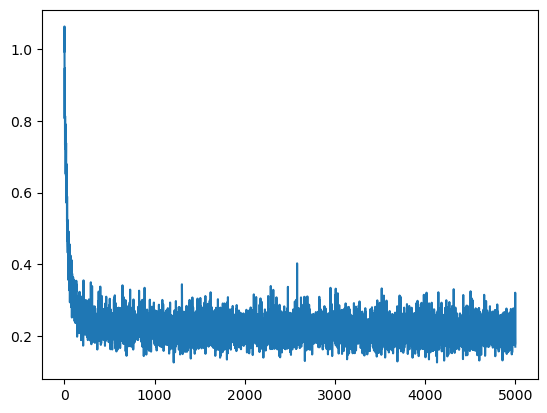

In [ ]:
plt.plot(loss_history)
plt.show()

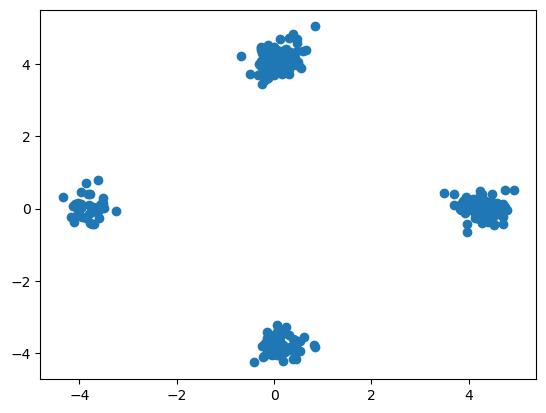

In [ ]:
ddpm = DDPM(linear_schedule(100), 100)
x_t = ddpm.sample(model, (256, 2), sample_with='ansesterial')

scatter(x_t)

## VP SDE

#### draw noising paths

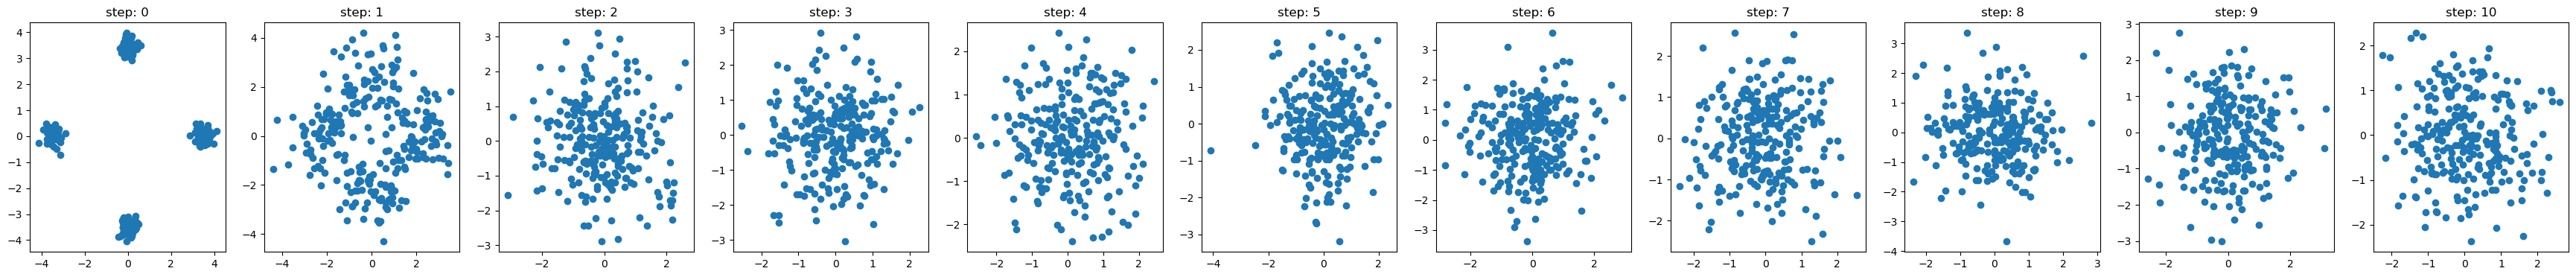

In [ ]:
vp = VPSDE(0.1, 20.0, n_steps=100)
x_0, x_1 = sampler.sample(256)

trajectory = [x_0]
for t in range(vp.n_steps // 10 - 1, vp.n_steps, vp.n_steps // 10):
    t = torch.ones(256) * t / vp.n_steps
    x_t = vp.sample_x_t_from_x_0(x_0, t)
    trajectory.append(x_t)

plot_trajectory(trajectory)

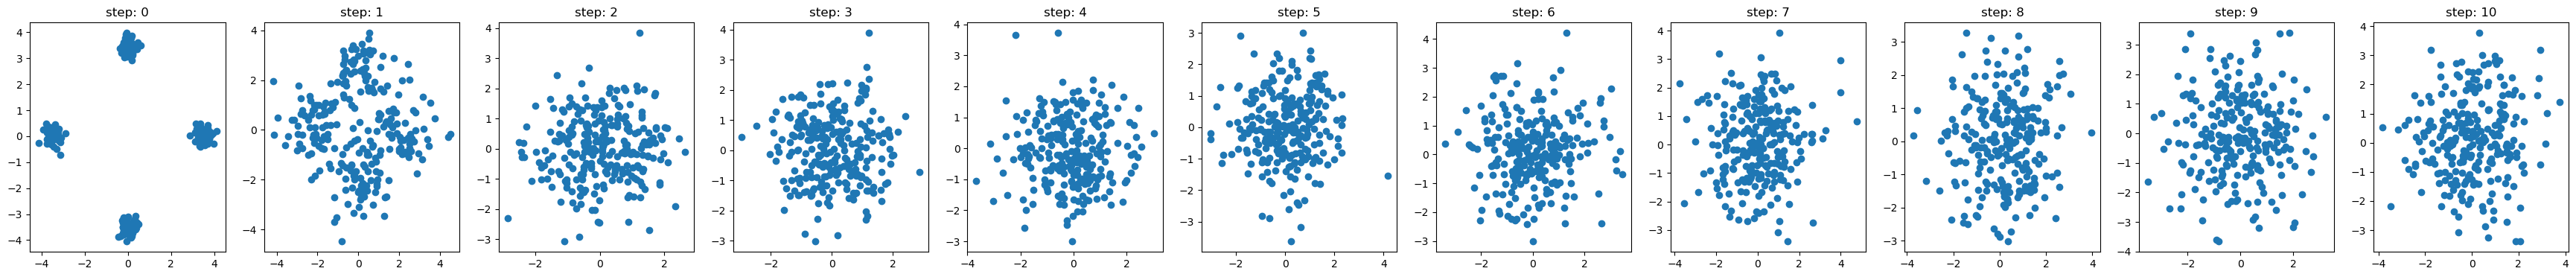

In [ ]:
x_t = x_0.clone()

trajectory = [x_0]
for i in range(vp.n_steps):
    t = torch.ones(256) * i / vp.n_steps
    x_t = x_t + vp.make_fwd_step(x_t, t)
    
    if (i + 1) % (vp.n_steps // 10) == 0:
        trajectory.append(x_t)

plot_trajectory(trajectory)

#### train

In [ ]:
B_SIZE = 256
N_STEPS = 5_000

vp = VPSDE(0.1, 20.0, n_steps=100)
score_model = SimpleNet(64, 64)
optim = torch.optim.AdamW(score_model.parameters(), lr=1e-3)

loss_history = []
for step in trange(N_STEPS):
    optim.zero_grad(set_to_none=True)
    
    x_0, _ = sampler.sample(B_SIZE)
    t = torch.rand(x_0.size(0))
    
    loss = vp.compute_loss(score_model, x_0, t, learn_score=False)
    
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())

  0%|          | 0/5000 [00:00<?, ?it/s]

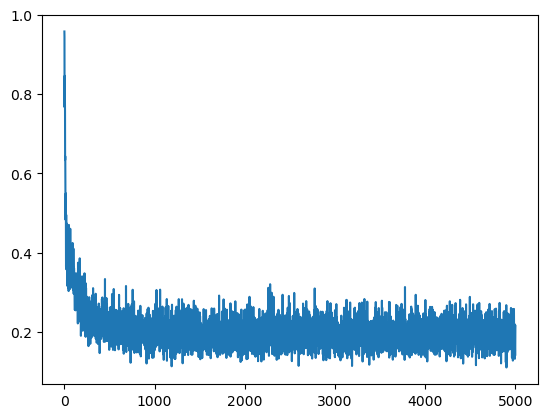

In [ ]:
plt.plot(loss_history)
plt.show()

In [ ]:
vp = VPSDE(0.1, 20.0, n_steps=100)
x_t = torch.randn(256, 2)
trajectory = [x_t]

for t in range(vp.n_steps - 1, -1, -1):
    t = torch.maximum(torch.ones(256) * t, torch.as_tensor(1e-3)) / vp.n_steps
    score = vp.score_from_noise(score_model, x_t, t)
    x_t = x_t + vp.make_bwd_step(score, x_t, t, ode_flow=False)
    
    trajectory.append(x_t)


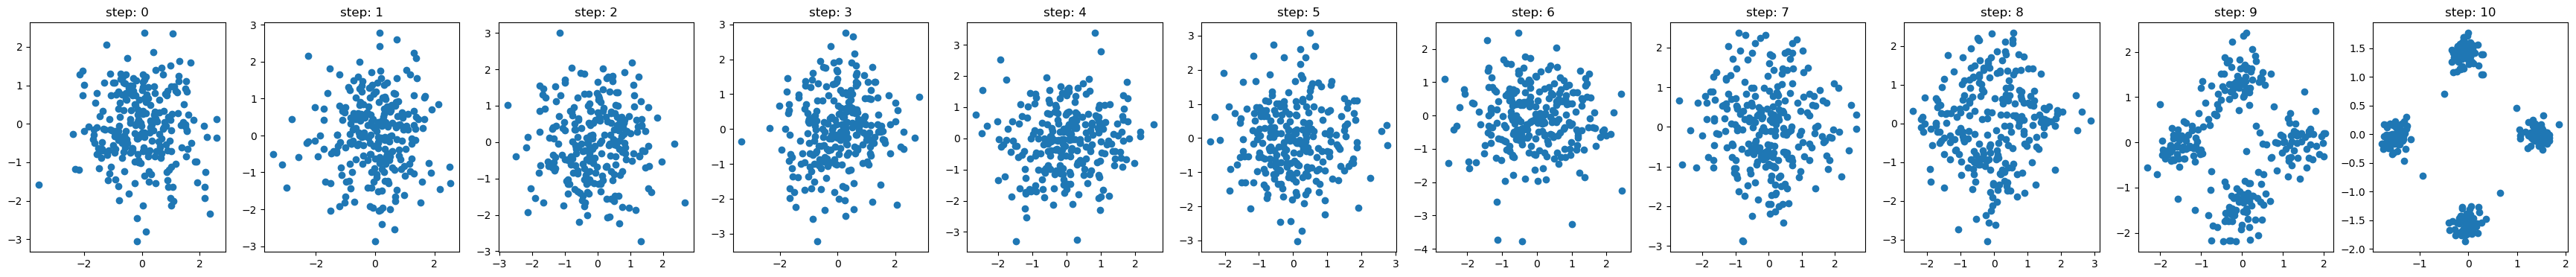

In [ ]:
plot_trajectory([trajectory[i] for i in [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100 - 1]])
# plot_trajectory(trajectory)

## VESDE & SMLD

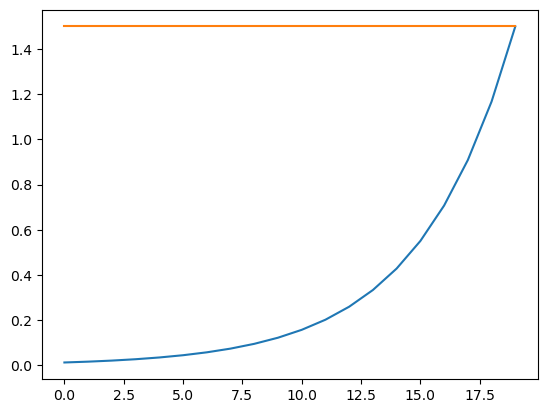

In [ ]:
sigma_min = 0.01
sigma_max = 1.5
n_steps = 20

step = (sigma_max / sigma_min) ** (1 / n_steps)
sigma_schedule = [sigma_min * step**(i+1) for i in range(n_steps)]
plt.plot(sigma_schedule)
plt.plot([sigma_max] * n_steps)
plt.show()

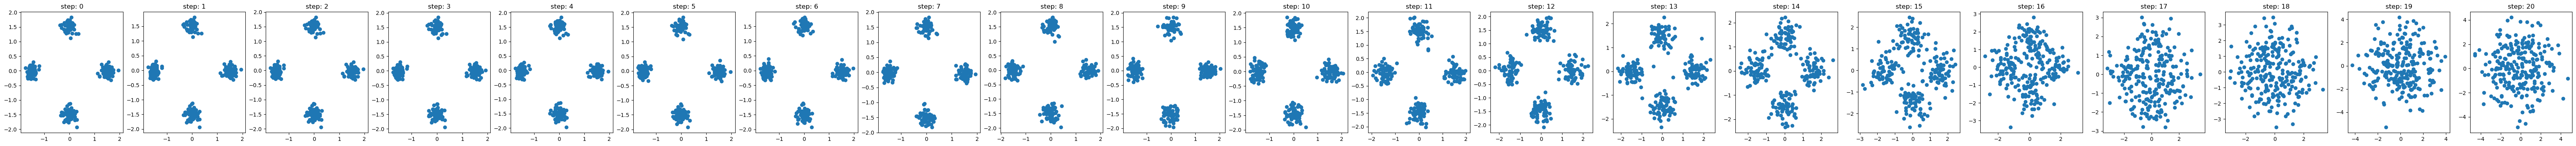

In [ ]:
x_0, _ = sampler.sample(256)

trajectory = [x_0]
for sigma in sigma_schedule:
    trajectory.append(x_0 + torch.randn_like(x_0) * sigma)

plot_trajectory(trajectory)

In [ ]:
sigma_min = 0.01
sigma_max = 1.5
n_steps = 20

sigma_coeff = (sigma_max / sigma_min) ** (1 / n_steps) 

In [341]:
score = SimpleNet(64, 64)
optim = torch.optim.AdamW(score.parameters(), lr=1e-3)

loss_history = []
for step in trange(N_STEPS):
    optim.zero_grad(set_to_none=True)
    
    x_0, _ = sampler.sample(256)
    steps = torch.randint(1, n_steps + 1, (x_0.size(0),))
    sigma = extract_into_tensor(sigma_min * (sigma_coeff) ** (steps), x_0.shape)
    
    x_sigma = x_0 + sigma * torch.randn_like(x_0)
    pred_score = score(x_sigma, sigma.squeeze(-1))
    true_score = - (x_sigma - x_0) / sigma**2
    loss = nn.functional.mse_loss(pred_score, true_score)
    
    loss.backward()
    optim.step()
    
    loss_history.append(loss.item())

NameError: name 'N_STEPS' is not defined

# Schrödinger Bridges

In [6]:
alpha = 4.0
gamma = 0.0006
t_max = 0.012
n_steps = 20


def ref_process(x, t):
    return ModelOutput(drift= - alpha * x)


def get_mean_log_var(model, x, t, dt):
    log_var = torch.as_tensor(2.0 * dt, device=x.device).log()
    output = model(x, t)
    
    if output.contains('log_var'):
        log_var = log_var + output.log_var
    
    mean = x + output.drift * dt
    return mean, log_var


def make_euler_maruyama_step(model, x, t, dt):
    mean, log_var = get_mean_log_var(model, x, t, dt)
    return mean + torch.randn_like(mean) * log_var.exp().sqrt()


def log_normal_density(x, mean, log_var):
    return - 0.5 * (log_var + torch.exp(- log_var) * (x - mean).pow(2)).sum(-1)


def sample_trajectory(model, x_start, direction, dt, n_steps, t_max, 
                      only_last: bool = False, return_timesteps: bool = False):
    assert direction in {"forward", "backward"}
    trajectory, timesteps = [x_start], [f"timestep {t_max if direction == 'backward' else 0}"]
    
    for t_step in (
            torch.linspace(dt, t_max, n_steps).flip(-1) \
            if direction == 'backward' \
            else torch.linspace(0, t_max - dt, n_steps)
        ):
        shift = - dt if direction == "backward" else + dt
        timesteps.append(f"timestep {t_step.item() + shift:.3f}")
        
        t = torch.ones(x_start.size(0)) * t_step
        trajectory.append(make_euler_maruyama_step(model, trajectory[-1], t, dt))
    
    if return_timesteps:
        return trajectory, timesteps
    
    if only_last:
        return trajectory[-1]
    
    return trajectory

## SB via IPF

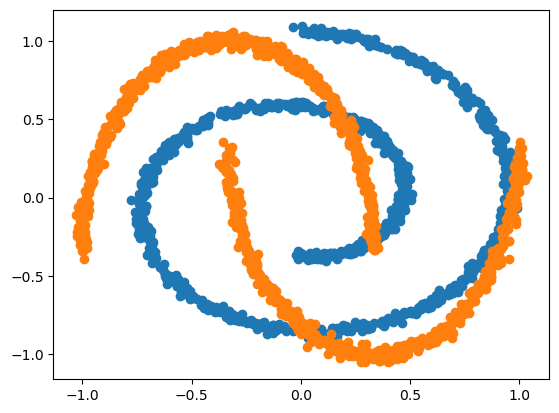

In [60]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigma = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    # p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_0='swiss_roll', p_0_args=[None, 0.2],
    p_1='two_moons', p_1_args=[None, 0.02],
    # p_1='checkboard', p_1_args=[None],
)
x_0, x_1 = sampler.sample(1024)
scatter(x_0)
scatter(x_1)
plt.show()

Losses:

In [118]:
def compute_fwd_tlm_loss(fwd_model, bwd_model, x_1, dt, t_max, n_steps, backward: bool = True):
    x_t = x_1
    traj_loss = 0

    for t_step in torch.linspace(dt, t_max, n_steps).flip(-1):
        t = torch.ones(512) * t_step
        
        with torch.no_grad():
            bwd_mean, bwd_log_var = get_mean_log_var(bwd_model, x_t, t, dt)
            x_t_m_dt = bwd_mean + torch.randn_like(bwd_mean) * bwd_log_var.exp().sqrt()
        
        fwd_mean, fwd_log_var = get_mean_log_var(fwd_model, x_t_m_dt, t - dt, dt)
        loss = log_normal_density(x_t, fwd_mean, fwd_log_var)                        
        
        if backward:
            (-loss).mean().backward()
        
        traj_loss = traj_loss + (-loss).mean()
        x_t = x_t_m_dt
    
    return traj_loss


def compute_bwd_tlm_loss(fwd_model, bwd_model, x_0, dt, t_max, n_steps, backward: bool = True):
    x_t_m_dt = x_0
    traj_loss = 0

    for t_step in torch.linspace(dt, t_max, n_steps):
        t = torch.ones(512) * t_step
        
        with torch.no_grad():
            bwd_mean, bwd_log_var = get_mean_log_var(fwd_model, x_t_m_dt, t - dt, dt)
            x_t = bwd_mean + torch.randn_like(bwd_mean) * bwd_log_var.exp().sqrt()
        
        bwd_mean, bwd_log_var = get_mean_log_var(bwd_model, x_t, t, dt)
        loss = log_normal_density(x_t_m_dt, bwd_mean, bwd_log_var)                        
        
        if backward:
            (-loss).mean().backward()
        
        traj_loss = traj_loss + (-loss).mean()
        x_t_m_dt = x_t
    
    return traj_loss



#### Train Forward Model (P0 --> P1) via mean matching

##### Check reference process

Reference process


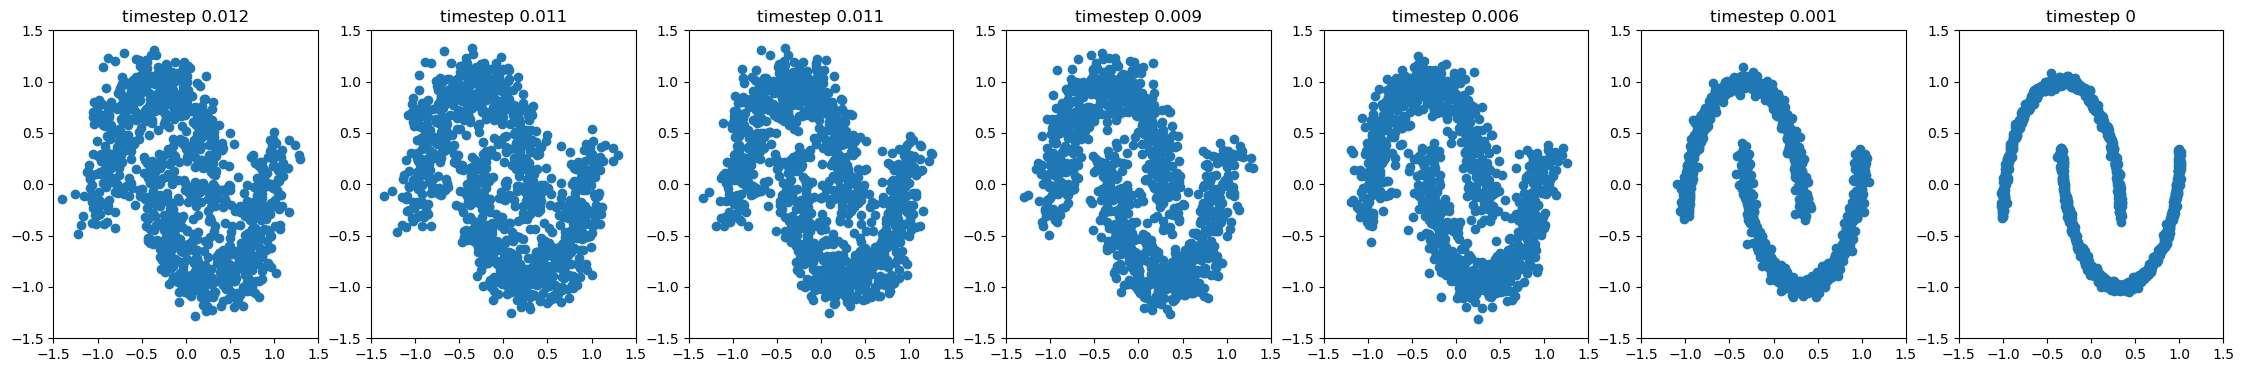

In [120]:
x_0,  x_1 = sampler.sample(1024)

traj, timesteps = sample_trajectory(ref_process, x_1, 'forward', gamma, n_steps, t_max, return_timesteps=True)

print('Reference process')
_ = plot_trajectory(traj[::-1], timesteps[::-1], indices=[0, 1, 2, 5, 10, -2, -1])

##### Train forward model

In [126]:
N_MAX_ITER = 10_000
PREDICT_LOGVAR = True

fwd_model = SimpleNet(64, 64, n_main_body_layers=3, predict_log_var=PREDICT_LOGVAR)
fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=7e-4)

ema_loss = utils.EMALoss(alpha=0.09)
var_crit = utils.VarCriterion(ema_loss.ema, threshold=1e-9, 
                              max_iter=N_MAX_ITER, measure_size=500)

with tqdm(total=N_MAX_ITER, leave=False) as pbar:
    while var_crit.check():
        fwd_optim.zero_grad(set_to_none=True)
        
        _, x_t = sampler.sample(512)
        traj_loss = compute_fwd_tlm_loss(fwd_model, ref_process, x_t, 
                                         gamma, t_max, n_steps)

        ema_loss.update(traj_loss.item() / n_steps)
        fwd_optim.step()
        
        pbar.update(1)

    pbar.close()

  0%|          | 0/10000 [00:00<?, ?it/s]

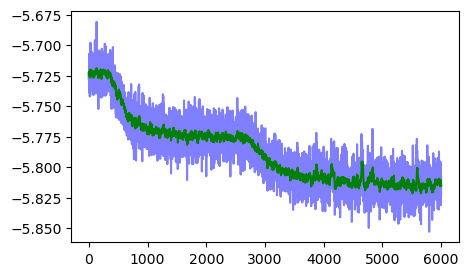

In [121]:
plt.figure(figsize=(5, 3))
plt.plot(ema_loss.loss, alpha=0.5, c='b')
plt.plot(ema_loss.ema, c='g')
plt.show()

Reference process


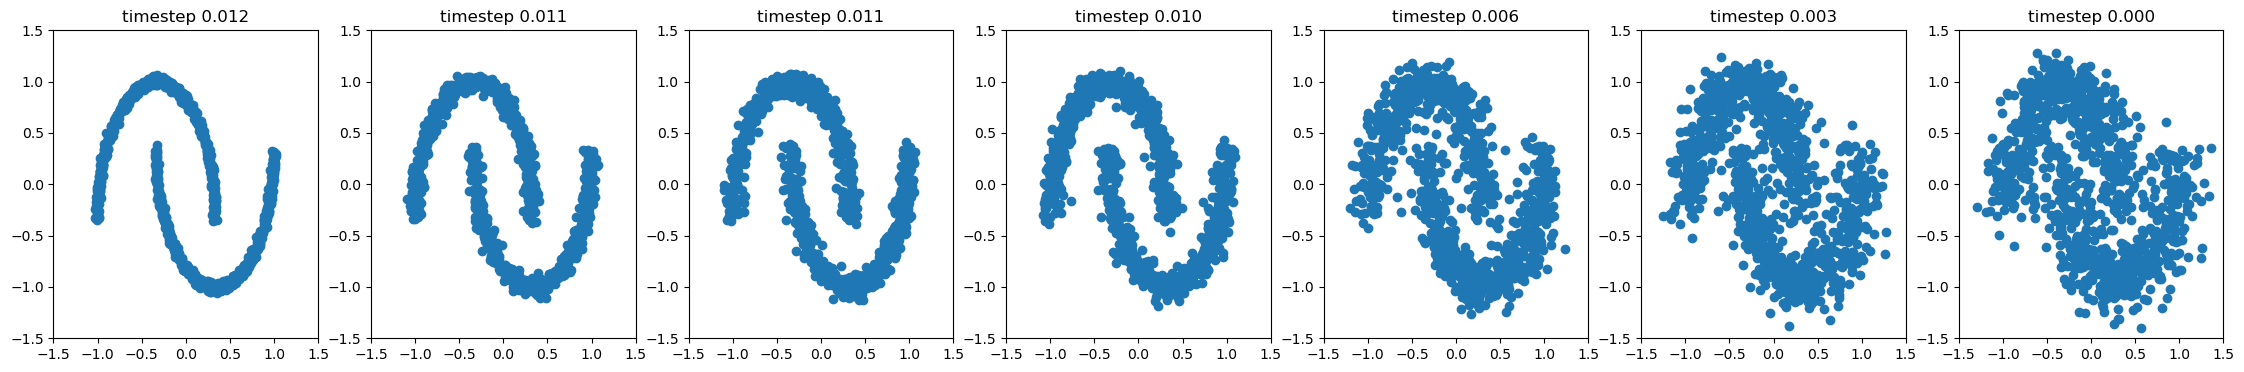

Learned trajectory for Forward Model


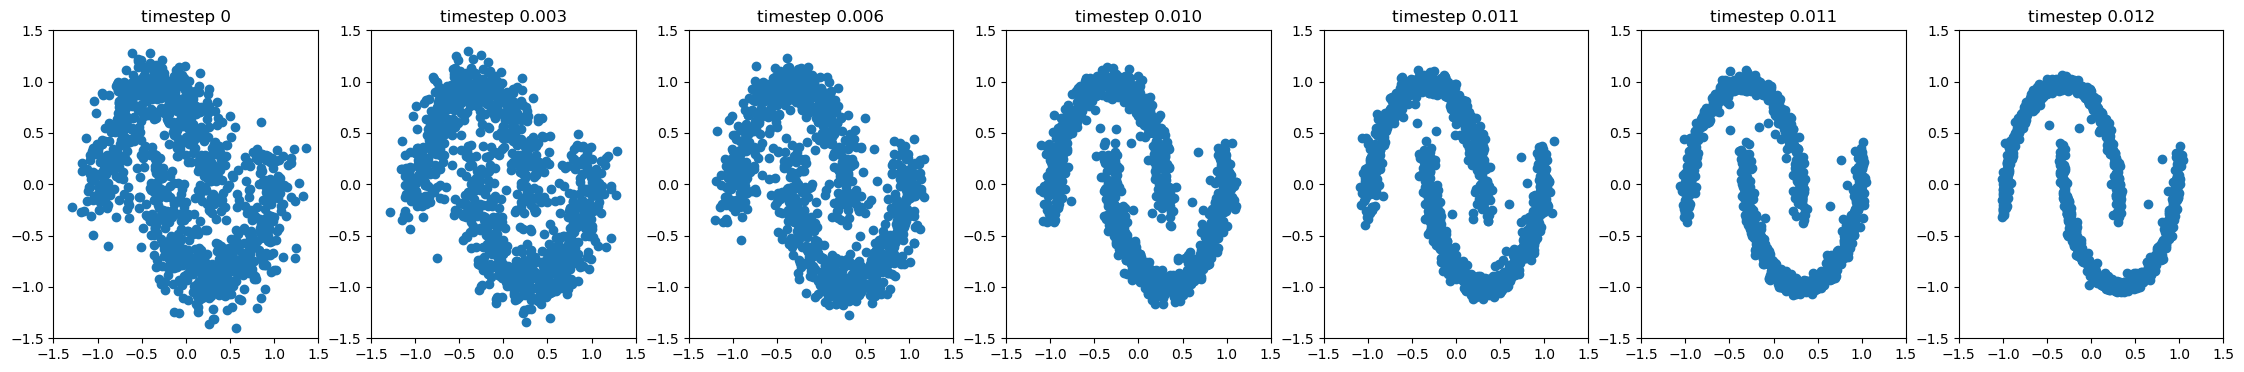

In [125]:
_, x_1 = sampler.sample(1024)

ref_traj, bwd_labels = sample_trajectory(ref_process, x_1, 'backward', gamma, 
                                         n_steps, t_max, return_timesteps=True)

print('Reference process')
f = plot_trajectory(ref_traj, bwd_labels, indices=[0, 1, 2, 3, 10, 15, -1])

with torch.no_grad():
    learned_traj, fwd_labels = sample_trajectory(fwd_model, ref_traj[-1], 'forward', gamma, 
                                                 n_steps, t_max, return_timesteps=True)

print('Learned trajectory for Forward Model')
f = plot_trajectory(learned_traj, fwd_labels, indices=[0, 5, 10, -4, -3, -2, -1])

#### Train Backward Model (P1 --> P0) via mean matching

##### Check reference process

Reference process


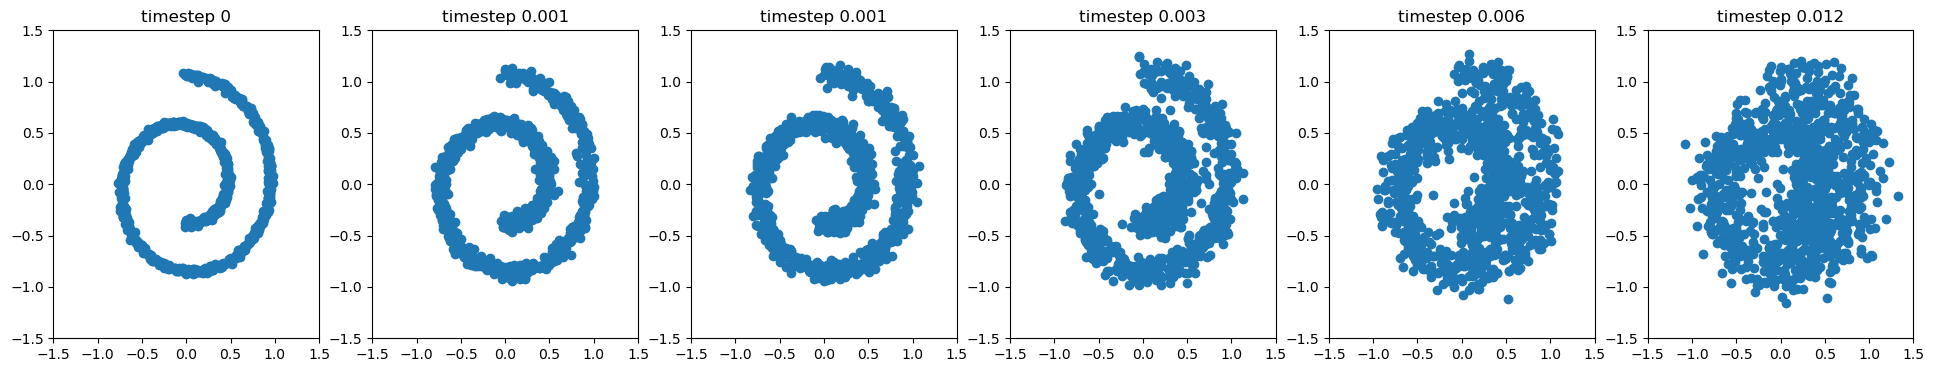

In [127]:
x_0, _ = sampler.sample(1024)

ref_traj, timesteps = sample_trajectory(ref_process, x_0, 'forward', gamma, 
                                        n_steps, t_max, return_timesteps=True)

print('Reference process')
_ = plot_trajectory(ref_traj, timesteps, indices=[0, 1, 2, 5, 10, -1])

##### Train backward model

In [128]:
N_MAX_ITER = 8_000
USE_MEAN_MATCHING = True

bwd_model = SimpleNet(64, 64, predict_log_var=True)
bwd_optim = torch.optim.Adam(bwd_model.parameters(), lr=7e-4)

ema_loss = utils.EMALoss()
var_crit = utils.VarCriterion(
    ema_loss.ema, threshold=1e-9, 
    max_iter=N_MAX_ITER, measure_size=1000
)

with tqdm(total=N_MAX_ITER, leave=False) as pbar:
    while var_crit.check():
        bwd_optim.zero_grad(set_to_none=True)

        x_t_m_dt, _ = sampler.sample(512)
        traj_loss = compute_bwd_tlm_loss(ref_process, bwd_model, x_t_m_dt, 
                                         gamma, t_max, n_steps)

        ema_loss.update(traj_loss.item() / n_steps)
        bwd_optim.step()

        pbar.update(1)
    pbar.close()

  0%|          | 0/8000 [00:00<?, ?it/s]

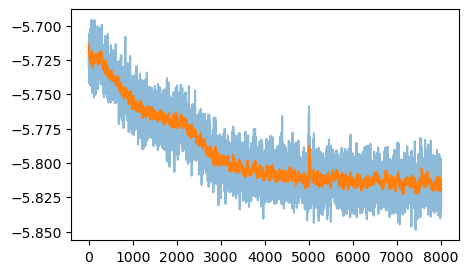

In [129]:
plt.figure(figsize=(5, 3))
plt.plot(ema_loss.loss, alpha=0.5)
plt.plot(ema_loss.ema)
plt.show()

Reference Trajectory


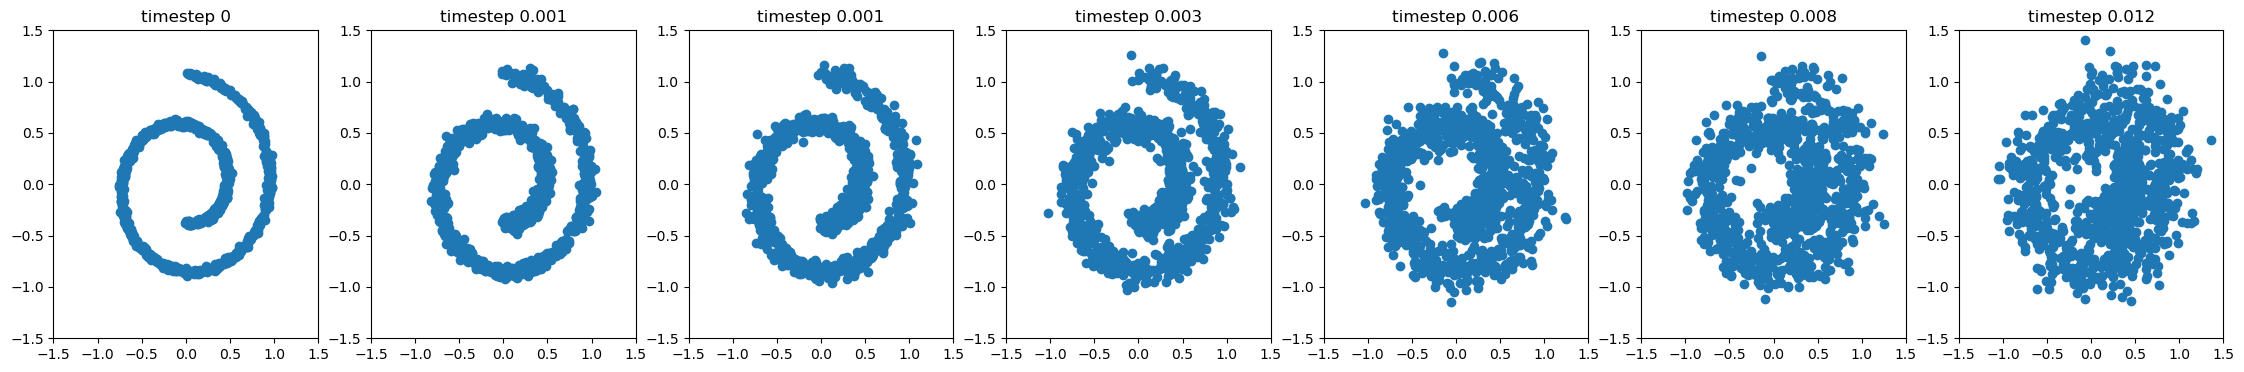

Learned Trajectory for F


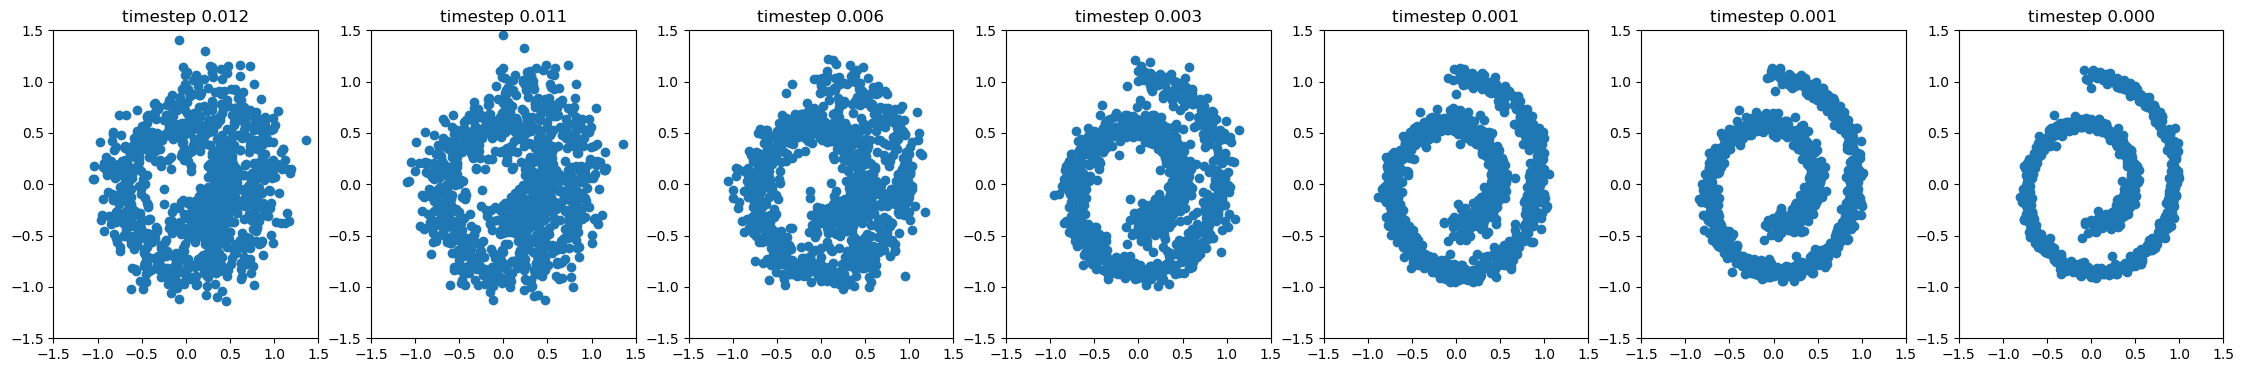

In [134]:
x_0, _  = sampler.sample(1024)

ref_traj, fwd_labels = sample_trajectory(ref_process, x_0, 'forward', gamma,
                                         n_steps, t_max, return_timesteps=True)

print('Reference Trajectory')
_ = plot_trajectory(ref_traj, fwd_labels, indices=[0, 1, 2, 5, 10, 15 -2, -1])

with torch.no_grad():
    learned_traj, bwd_labels = sample_trajectory(bwd_model, ref_traj[-1], 'backward', gamma,
                                                 n_steps, t_max, return_timesteps=True)

print('Learned Trajectory for F')
_ = plot_trajectory(learned_traj, bwd_labels, indices=[0, 1, 10, 15, -3, -2, -1])

#### Full SBM

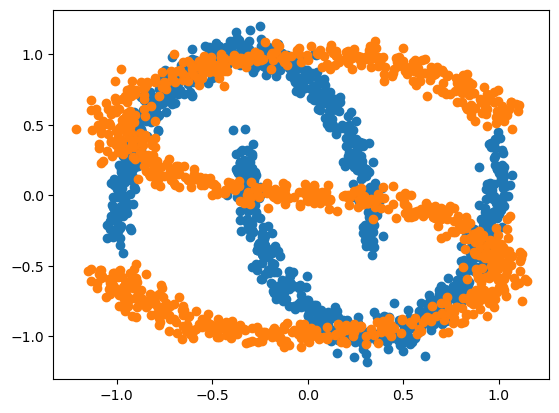

In [21]:
mean = torch.tensor([[-1, 1], [1, 1], [1, -1], [-1, -1]]) * 1.0
sigma = torch.ones_like(mean) * 0.1

sampler = DatasetSampler(
    # p_0='mix_of_gaussians', p_0_args=[mean, sigmas],
    p_0='two_moons', p_0_args=[None, 0.05],
    p_1='s_curve', p_1_args=[None, 0.09],
)
x_0, x_1 = sampler.sample(1024)
scatter(x_0)
scatter(x_1)
plt.show()

In [13]:

# sb_trainer = SBTrainer(
#     F=F_model, B=B_model,
#     sampler=sampler,
#     alpha=4.0,
#     gamma=0.0006,
#     batch_size=256,
#     threshold=5e-6,
#     num_sb_steps=20,
#     lr_forward=8e-4,
#     lr_backward=8e-4,
#     max_num_iters_per_step=MAX_CONVERGENCE_ITER,
# )
# sb_trainer.train()

In [ ]:
def ref_process(x, t):
    return ModelOutput(drift=-gamma * alpha * x)


alpha = 4
gamma = 0.0006
t_max = 0.0120
n_steps = 20

BATCH_SIZE = 256
NUM_SB_ITERATIONS = 20
MAX_CONVERGENCE_ITER = 6000

B_model = SimpleNet(64, 64, predict_log_var=True)
F_model = SimpleNet(64, 64, predict_log_var=True)

optim_B = torch.optim.Adam(B_model.parameters(), lr=8e-4)
optim_F = torch.optim.Adam(F_model.parameters(), lr=8e-4)

## Energy based SB

## Data to Energy 

### Gaussian Energy

In [8]:
class GaussMix:
    def __init__(self, means, sigmas):
        mix = distributions.Categorical(torch.ones(means.size(0), device=means.device))
        comp = distributions.Independent(distributions.Normal(means, sigmas), 1)
        self.gmm = distributions.MixtureSameFamily(mix, comp)

        self._grad = torch.func.grad(lambda y: self.log_prob(y).sum())

    def  to(self, device='cpu'):
        self.gmm.to(device)

    def log_prob(self, x):
        return self.gmm.log_prob(x)
    
    def grad(self, x):
        return self._grad(x)

In [9]:
def draw_level_lines(func, samples=None):
    x = np.linspace(-2, 2, 100)  # Define x-axis range
    y = np.linspace(-2, 2, 100)  # Define y-axis range
    X, Y = np.meshgrid(x, y)     # Create grid of points

    grid_points = np.stack([X, Y], axis=-1)  # Shape: [100, 100, 2]

    grid_points = torch.from_numpy(grid_points).reshape(-1, 2).float()
    Z = func(grid_points).numpy()  # Shape: [100, 100]
    Z = Z.reshape(100, 100)

    plt.figure()
    contour = plt.contour(X, Y, Z, levels=7, colors='k')  # Draw contour lines
    plt.clabel(contour, inline=True, fontsize=6)           # Add labels to contours
    plt.contourf(X, Y, Z, levels=10, cmap='viridis', alpha=0.5)       # Filled contours for visualization
    if samples is not None:
        plt.scatter(samples[:, 0], samples[:, 1], c='r')
    plt.colorbar(label='Function Value')                  # Add color bar
    plt.title('Level Lines of the Function')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

### TB and PIS losses

##### Configure data

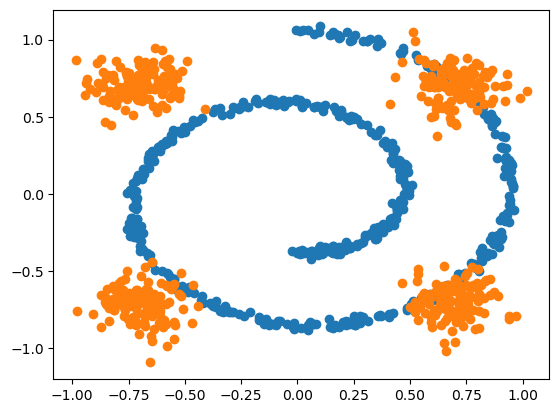

In [10]:
# means0 = torch.tensor([[-0.3, 0], [0.3, 0]])
# sigmas0 = torch.ones(1, 2) * 0.1

means1 = rotate_mean(
    torch.tensor([[-1, 1],[-1, -1],[1, 1],[1, -1]]).float() * 0.7, 
    torch.pi
)
sigmas1 = torch.ones_like(means1) * 0.1

# log_p_0 = GaussMix(means0, sigmas0)
log_p_1 = GaussMix(means1, sigmas1)

sampler = DatasetSampler(
    p_0='swiss_roll', p_0_args=[None, 0.2],
    p_1='mix_of_gaussians', p_1_args=[means1, sigmas1],
)

x_0, x_1 = sampler.sample(512)

scatter(x_0)
scatter(x_1)

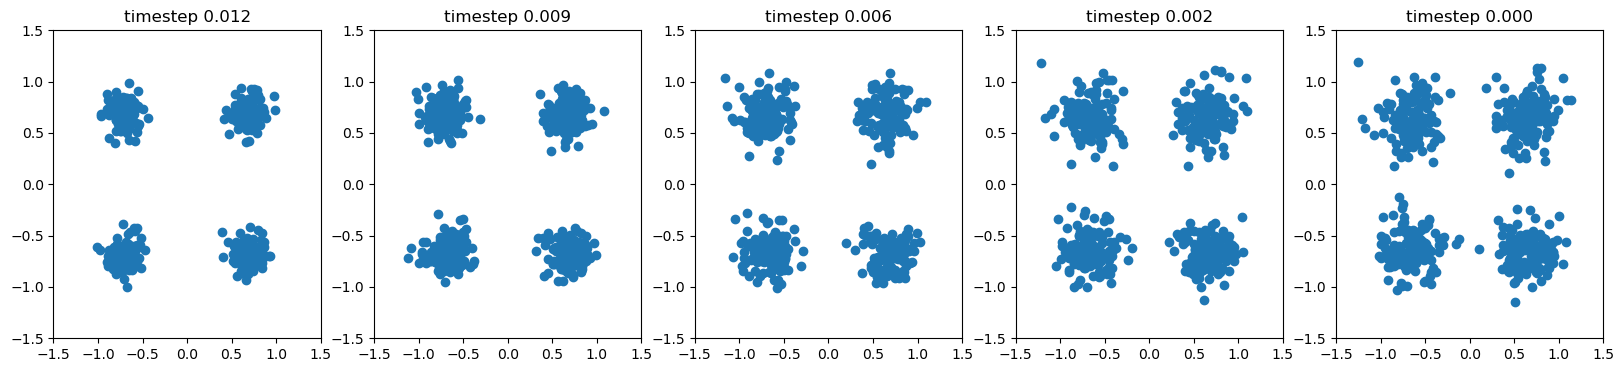

In [11]:
_, x_1 = sampler.sample(512)
trajectory, timesteps = sample_trajectory(ref_process, x_1, 'backward', gamma, 
                                          n_steps, t_max, return_timesteps=True)

_ = plot_trajectory(trajectory, timesteps, indices=[0, 5, 10, -5, -1])

##### Train one step for debugging

In [38]:
DEVICE = 'cpu'
N_MAX_ITER = 6_000
OBJECTIVE = 'CTB'
PREDICT_LOGVAR = True

means = torch.tensor([[-1, 1],[-1, -1],[1, 1],[1, -1]], device=DEVICE).float() * 0.7
sigmas = torch.ones_like(means, device=DEVICE) * 0.08

fwd_model = SimpleNet(64, 64, n_main_body_layers=3, 
                      predict_log_var=PREDICT_LOGVAR).to(DEVICE)
fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=7e-4)

ema_loss_ctb = utils.EMALoss(alpha=0.09)
for _ in trange(N_MAX_ITER):
    fwd_optim.zero_grad(set_to_none=True)

    # with torch.no_grad():
    #     _, x_1 = sampler.sample(512)
        # x_0 = torch.randn_like(x_0)
        # x_0[x_0.size(0) // 2 :] = sample_trajectory(ref_process, x_1, "backward", 
        #                                             gamma, n_steps, t_max, 
        #                                             only_last=True)[x_0.size(0) // 2:]
    
    _, x_1 = sampler.sample(512)
    loss = losses.compute_fwd_ctb_loss_ver2(fwd_model, ref_process, log_p_1.log_prob, 
                                             x_1, gamma, t_max, n_steps)

    loss.backward()
    fwd_optim.step()

    ema_loss_ctb.update(loss.mean().item() / n_steps)


  0%|          | 0/6000 [00:00<?, ?it/s]

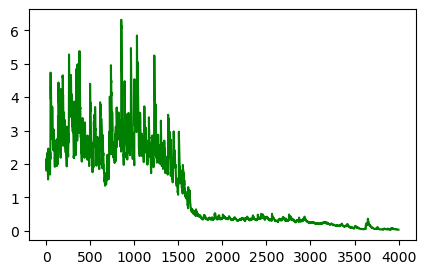

In [36]:
plt.figure(figsize=(5, 3))
plt.plot(ema_loss_ctb.ema[:], c='g')
plt.show()

Reference process


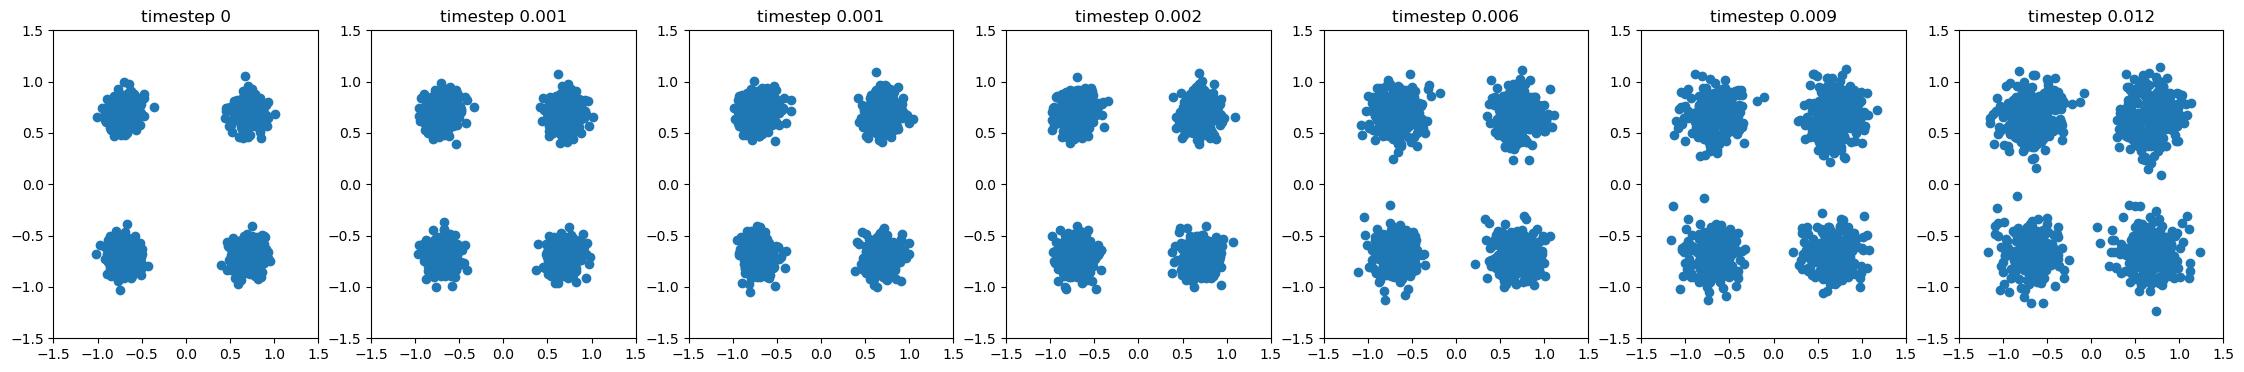

Learned process


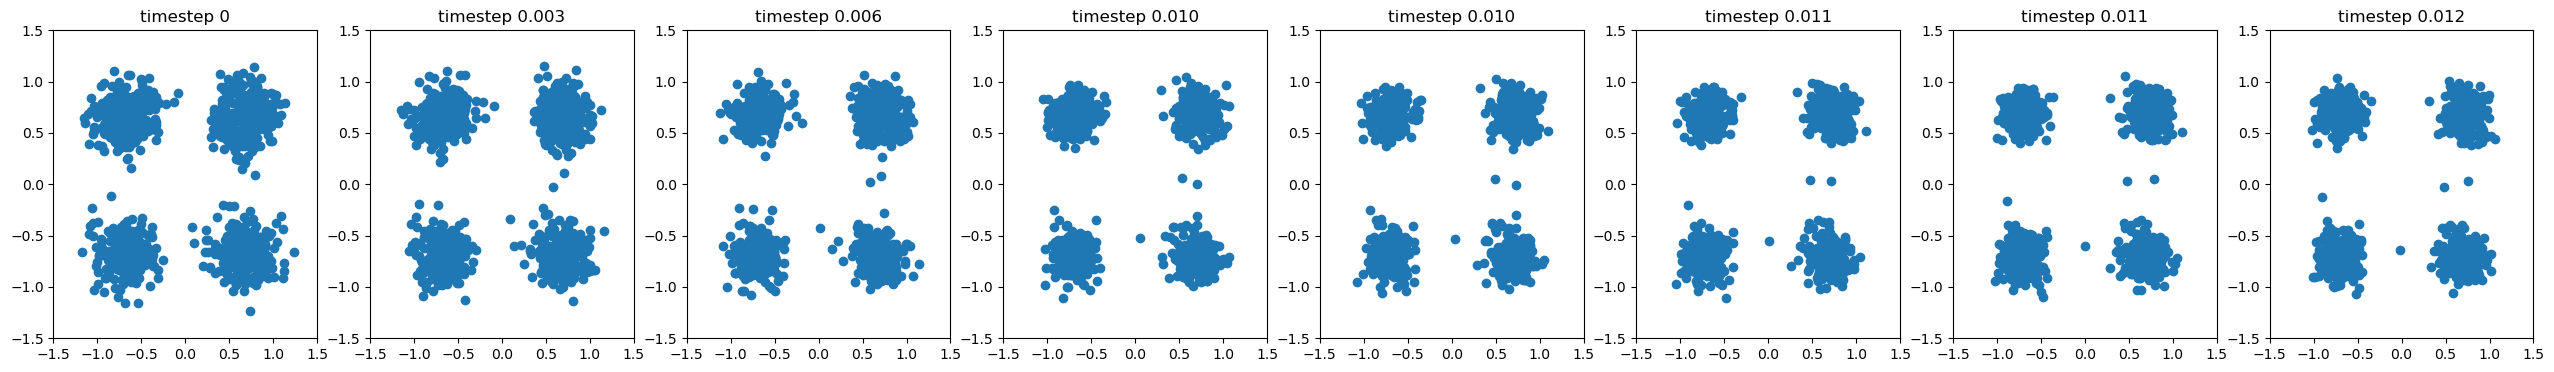

In [37]:
x_0, x_1 = sampler.sample(1024)
ref_traj, ref_timesteps = sample_trajectory(ref_process, x_1, "backward", gamma,
                                            n_steps, t_max, return_timesteps=True)
print('Reference process')
f_reference = plot_trajectory(ref_traj, timesteps, indices=[0, 1, 2, 3, 10, 15, -1])

# ----------------------------------------------------------------------------------------------

with torch.no_grad():
    learned_traj, forward_timesteps = sample_trajectory(fwd_model, ref_traj[-1], "forward", gamma,
                                                        n_steps, t_max, return_timesteps=True)
print('Learned process')
f_learned = plot_trajectory(learned_traj, forward_timesteps, indices=[0, 5, 10, -5, -4, -3, -2, -1])

##### Full model Training

  0%|          | 0/2 [00:00<?, ?it/s]

It 0 | Backward:   0%|          | 0/6000 [00:00<?, ?it/s]

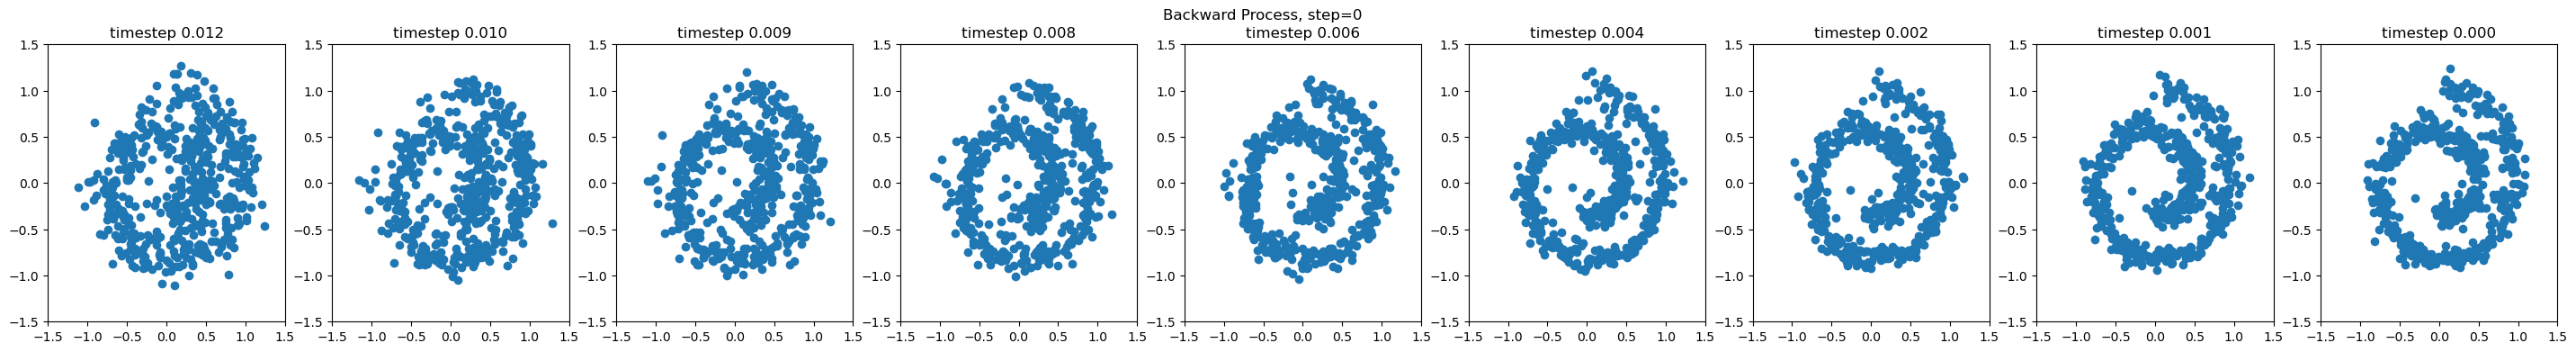

It 0 | Forward:   0%|          | 0/6000 [00:00<?, ?it/s]

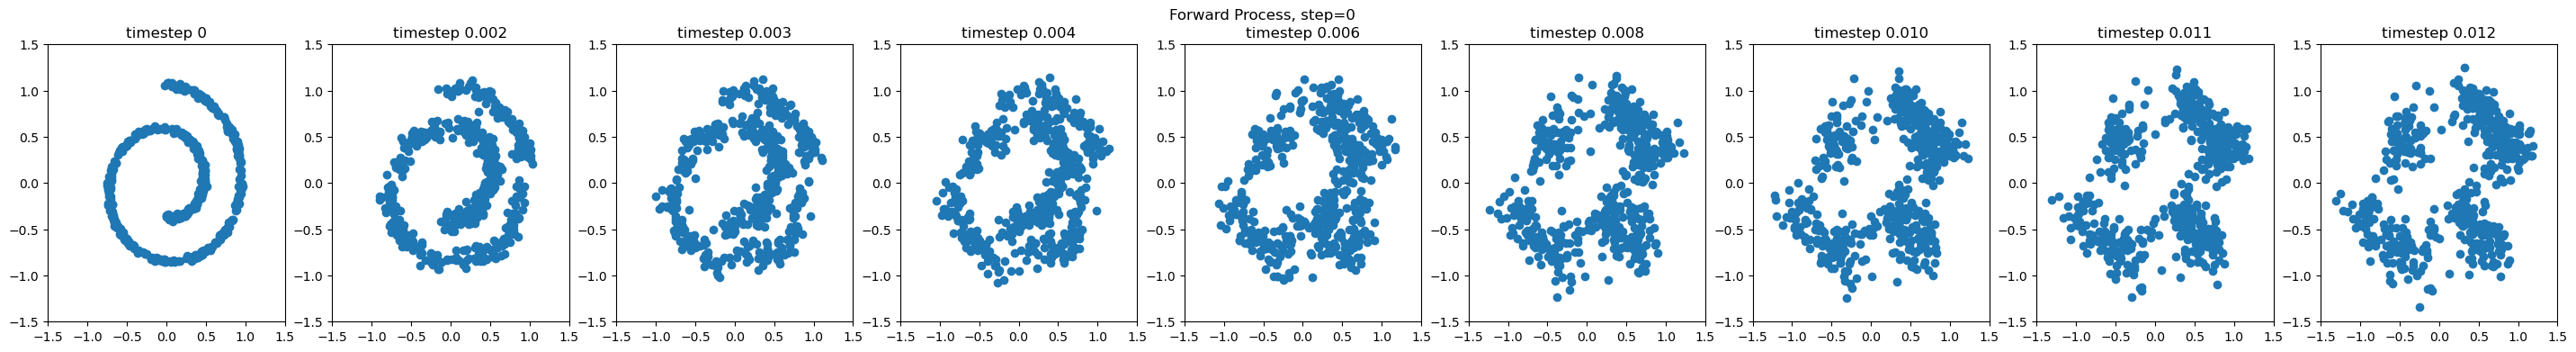

It 1 | Backward:   0%|          | 0/6000 [00:00<?, ?it/s]

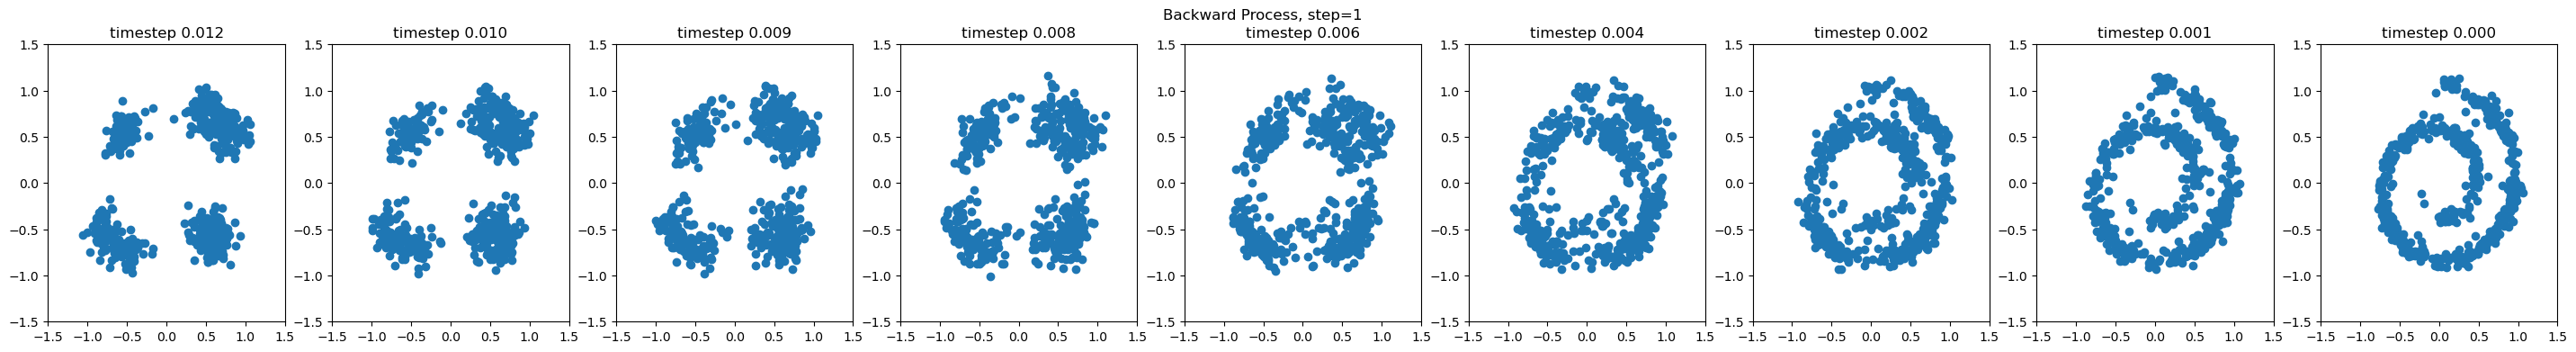

It 1 | Forward:   0%|          | 0/6000 [00:00<?, ?it/s]

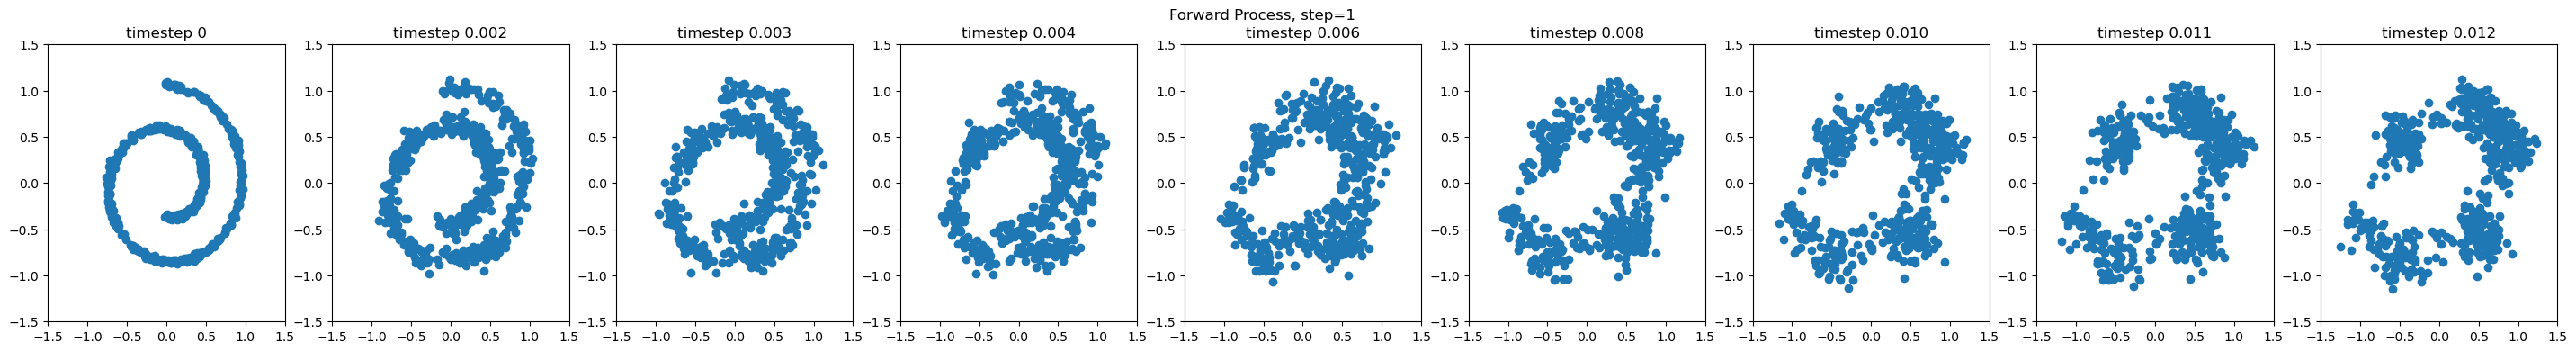

In [33]:
DEVICE = "cpu"
N_SB_STEPS = 2
N_MAX_ITER = 6_000
PREDICT_LOGVAR = False

fwd_model = SimpleNet(64, 64, n_main_body_layers=3, 
                      predict_log_var=False).to(DEVICE)
bwd_model = SimpleNet(64, 64, n_main_body_layers=3, 
                      predict_log_var=False).to(DEVICE)

fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=1e-3)
bwd_optim = torch.optim.Adam(bwd_model.parameters(), lr=7e-4)

fwd_ema_loss = utils.EMALoss(0.1)
bwd_ema_loss = utils.EMALoss(0.1)

p1_buffer = LangevinReplayBuffer(1024, log_p_1.grad, 0.001, 5)


for it in trange(N_SB_STEPS):
    # BACKWARD PROCESS
    for _ in trange(N_MAX_ITER, leave=False, desc=f'It {it} | Backward'):
        bwd_optim.zero_grad(set_to_none=True)

        x_0, _ = sampler.sample(512)
        traj_loss = losses.compute_bwd_tlm_loss(ref_process if it == 0 else fwd_model, 
                                                bwd_model, x_0, gamma, t_max, n_steps)
            
        bwd_optim.step()
        bwd_ema_loss.update(traj_loss.item() / n_steps)

    with torch.no_grad():
        if it == 0:
            x_0, _ = sampler.sample(512)
            x_1 = sample_trajectory(ref_process, x_0, "forward", gamma, 
                                    n_steps, t_max, only_last=True)
        else:
            x_1 = p1_buffer.sample(512)
        
        bwd_trajectory, timesteps = sample_trajectory(bwd_model, x_1, "backward", gamma, 
                                                      n_steps, t_max, return_timesteps=True)
        _ = plot_trajectory(bwd_trajectory, timesteps, 
                            indices=[0, 3, 5, 7, 10, -7, -5, -3, -1], title=f"Backward Process, step={it}")

    # FORWARD PROCESS
    for _ in trange(N_MAX_ITER, leave=False, desc=f'It {it} | Forward'):
        fwd_optim.zero_grad(set_to_none=True)

        if it == 0:
            x_0, _ = sampler.sample(512)
        else: 
            x_1_buffer = p1_buffer.sample(512)
            with torch.no_grad():
                x_0 = sample_trajectory(bwd_model, x_1_buffer, "backward", gamma,
                                        n_steps, t_max, only_last=True)
        
        loss = losses.compute_fwd_ctb_loss(fwd_model, bwd_model, log_p_1.log_prob, 
                                           x_0, gamma, t_max, n_steps, 
                                           p1_buffer=p1_buffer)

        loss.backward()
        fwd_optim.step()

        fwd_ema_loss.update(loss.mean().item() / n_steps)

    with torch.no_grad():
        x_0, _ = sampler.sample(512)
        fwd_trajectory, timesteps = sample_trajectory(fwd_model, x_0, "forward", gamma, 
                                                    n_steps, t_max, return_timesteps=True)
        _ = plot_trajectory(fwd_trajectory, timesteps, 
                            indices=[0, 3, 5, 7, 10, -7, -5, -3, -1], title=f"Forward Process, step={it}")


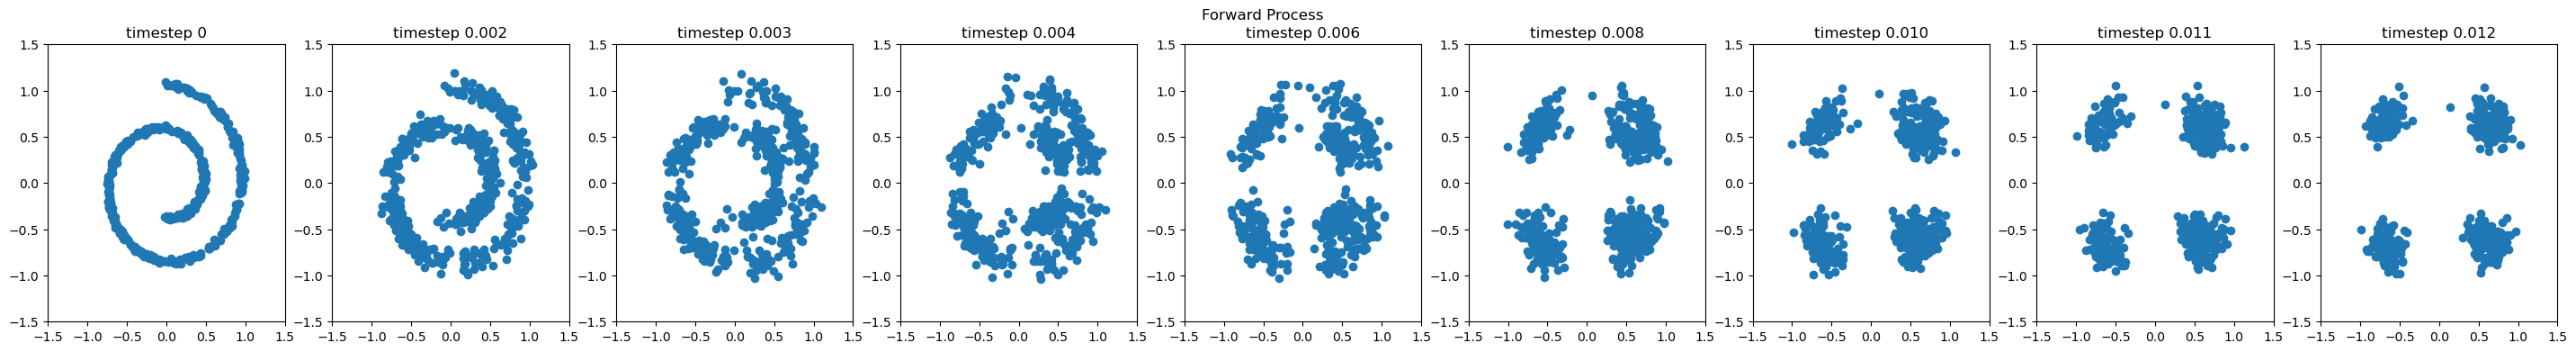

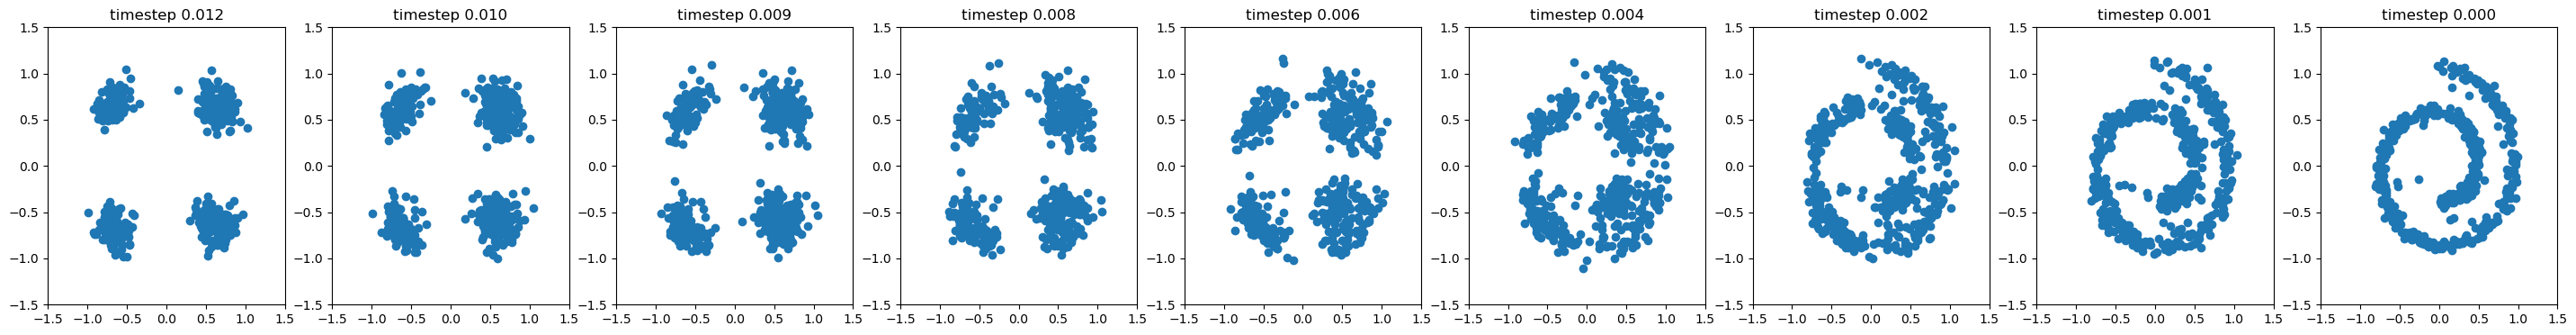

In [31]:
x_0, _ = sampler.sample(512)

with torch.no_grad():
    fwd_trajectory, timesteps = sample_trajectory(fwd_model, x_0, "forward", gamma, 
                                                  n_steps, t_max, return_timesteps=True)
_ = plot_trajectory(fwd_trajectory, timesteps, 
                    indices=[0, 3, 5, 7, 10, -7, -5, -3, -1], title="Forward Process")


with torch.no_grad():
    bwd_trajectory, timesteps = sample_trajectory(bwd_model, fwd_trajectory[-1], "backward", gamma, 
                                                  n_steps, t_max, return_timesteps=True)
_ = plot_trajectory(bwd_trajectory, timesteps, indices=[0, 3, 5, 7, 10, -7, -5, -3, -1])

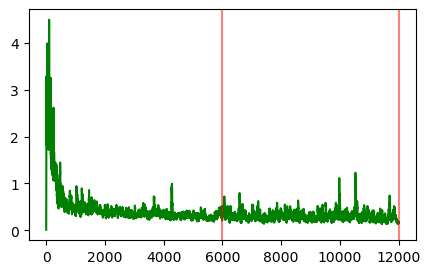

In [20]:
plt.figure(figsize=(5, 3))

plt.plot(fwd_ema_loss.ema, c='g')
plt.axvline(x = 6000, color = 'r', alpha=.5)
plt.axvline(x = 2 * 6000, color = 'r', alpha=.5)

plt.show()

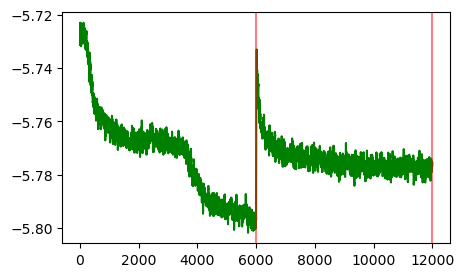

In [21]:
plt.figure(figsize=(5, 3))

plt.plot(bwd_ema_loss.ema, c='g')
plt.axvline(x = 6000, color = 'r', alpha=.5)
plt.axvline(x = 2 * 6000, color = 'r', alpha=.5)

plt.show()

## Energy to Energy

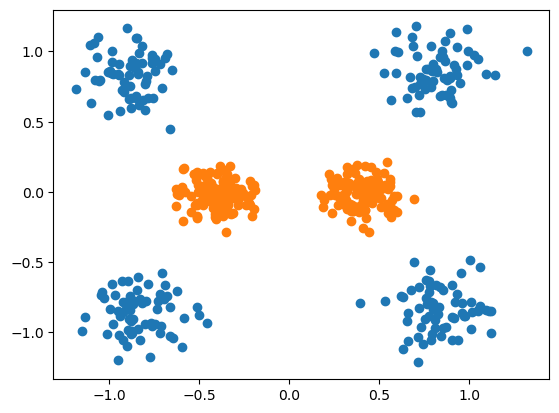

In [233]:
means_p_0 = rotate_mean(torch.tensor([[1, 0], [-1, 0], [0, 1], [0, -1]], dtype=torch.float) * 1.2, torch.pi / 4)
sigms_p_0 = torch.ones_like(means_p_0) * 0.15

means_p_1 = torch.tensor([[-0.4, 0], [0.4, 0]], dtype=torch.float)
sigms_p_1 = torch.ones_like(means_p_1) * 0.1

log_p_0 = GaussMix(means_p_0, sigms_p_0)
log_p_1 = GaussMix(means_p_1, sigms_p_1)

sampler = DatasetSampler(
    p_0='mix_of_gaussians', p_0_args=[means_p_0, sigms_p_0],
    p_1='mix_of_gaussians', p_1_args=[means_p_1, sigms_p_1]
)
x0, x1 = sampler.sample(256)
scatter(x0)
scatter(x1)

In [ ]:
LangevinReplayBuffer

In [ ]:
def compute_tb_loss(fwd_model, bwd_model, log_p_0, log_p_1, x_proposal, dt, t_max, n_steps, train: str = 'forward'):
    assert train in {"forward", "backward"}, "Can train either forward or backward policy"

    if train == "forward":
        timesteps = torch.linspace(dt, t_max, n_steps)
        fwd_tl_sum, bwd_tl_sum = log_p_0(x_proposal), 0
        x_t_m_dt = x_proposal
    else:  # train == 'backward'
        timesteps = torch.linspace(dt, t_max, n_steps).flip(-1)
        fwd_tl_sum, bwd_tl_sum = 0, log_p_1(x_proposal)
        x_t = x_proposal

    for t_step in timesteps:
        t = torch.ones(x_proposal.size(0)) * t_step

        if train == "forward":
            fwd_mean, fwd_log_var = get_mean_log_var(fwd_model, x_t_m_dt, t - dt, dt)
            with torch.no_grad():
                x_t = fwd_mean + fwd_log_var.exp().sqrt() * torch.randn_like(fwd_log_var)
            
            fwd_tl_sum = fwd_tl_sum + log_normal_density(x_t, fwd_mean, fwd_log_var)

            with torch.no_grad():
                bwd_mean, bwd_log_var = get_mean_log_var(bwd_model, x_t, t, dt)
                bwd_tl_sum = bwd_tl_sum + log_normal_density(x_t_m_dt, bwd_mean, bwd_log_var)

            x_t_m_dt = x_t
        else:  # train == 'backward'
            bwd_mean, bwd_log_var = get_mean_log_var(bwd_model, x_t, t, dt)
            with torch.no_grad():
                x_t_m_dt = bwd_mean + bwd_log_var.exp().sqrt() * torch.randn_like(bwd_log_var)

            bwd_tl_sum = bwd_tl_sum + log_normal_density(x_t_m_dt, bwd_mean, bwd_log_var)

            with torch.no_grad():
                fwd_mean, fwd_log_var = get_mean_log_var(fwd_model, x_t_m_dt, t - dt, dt)
                fwd_tl_sum = fwd_tl_sum + log_normal_density(x_t, fwd_mean, fwd_log_var)
            
            x_t = x_t_m_dt
    
    if train == "forward":
        bwd_tl_sum = bwd_tl_sum + log_p_1(x_t_m_dt)
        return (fwd_tl_sum - bwd_tl_sum).pow(2).mean(), x_t_m_dt
    else:  # train == 'backward'
        fwd_tl_sum = fwd_tl_sum + log_p_0(x_t)
        return (fwd_tl_sum - bwd_tl_sum).pow(2).mean(), x_t

In [254]:
N_IPF_ITER = 3
N_TRAIN_STEPS = 1000
PREDICT_LOGVAR = True

p0_buffer = ReplayBuffer(1024)
p1_buffer = ReplayBuffer(1024)

fwd_model = SimpleNet(64, 64, n_main_body_layers=3, predict_log_var=PREDICT_LOGVAR)
bwd_model = SimpleNet(64, 64, n_main_body_layers=3, predict_log_var=PREDICT_LOGVAR)

fwd_optim = torch.optim.Adam(fwd_model.parameters(), lr=7e-4)
bwd_optim = torch.optim.Adam(bwd_model.parameters(), lr=7e-4)

fwd_ema_loss_ctb = utils.EMALoss(0.1)
bwd_ema_loss_ctb = utils.EMALoss(0.1)

for it in trange(N_IPF_ITER):
    # FORWARD PROCESS
    for _ in trange(N_MAX_ITER, leave=False, desc=f"It {it} | Forward"):
        fwd_optim.zero_grad(set_to_none=True)

        x_0 = torch.randn(512, 2) if it == 0 else p0_buffer.sample(512)
        loss = losses.compute_fwd_ctb_loss(fwd_model, bwd_model if it > 0 else ref_process, 
                                           log_p_1.log_prob, x_0, gamma, t_max, n_steps, 
                                           p1_buffer=p1_buffer)

        loss.backward()
        fwd_optim.step()

        fwd_ema_loss_ctb.update(loss.mean().item() / n_steps)

    # BACKWARD PROCESS
    for _ in trange(N_MAX_ITER, leave=False, desc=f"It {it} | Backward"):
        bwd_optim.zero_grad(set_to_none=True)
        
        x_1 = p1_buffer.sample(512)
        loss = losses.compute_bwd_ctb_loss(fwd_model, bwd_model, log_p_0.log_prob, 
                                           x_1, gamma, t_max, n_steps, p0_buffer=p0_buffer)

        loss.backward()
        bwd_optim.step()

        bwd_ema_loss_ctb.update(loss.mean().item() / n_steps)

  0%|          | 0/3 [00:00<?, ?it/s]

It 0 | Forward:   0%|          | 0/6000 [00:00<?, ?it/s]

It 0 | Backward:   0%|          | 0/6000 [00:00<?, ?it/s]

It 1 | Forward:   0%|          | 0/6000 [00:00<?, ?it/s]

It 1 | Backward:   0%|          | 0/6000 [00:00<?, ?it/s]

It 2 | Forward:   0%|          | 0/6000 [00:00<?, ?it/s]

It 2 | Backward:   0%|          | 0/6000 [00:00<?, ?it/s]

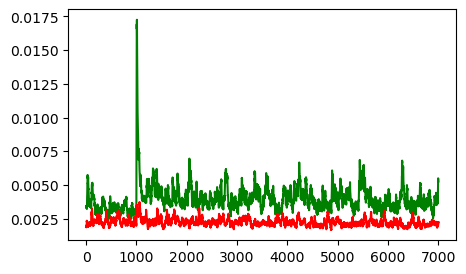

In [269]:
plt.figure(figsize=(5, 3))
plt.plot(fwd_ema_loss_ctb.ema[-7000:], c='g')
plt.plot(bwd_ema_loss_ctb.ema[-7000:], c='r')
plt.show()

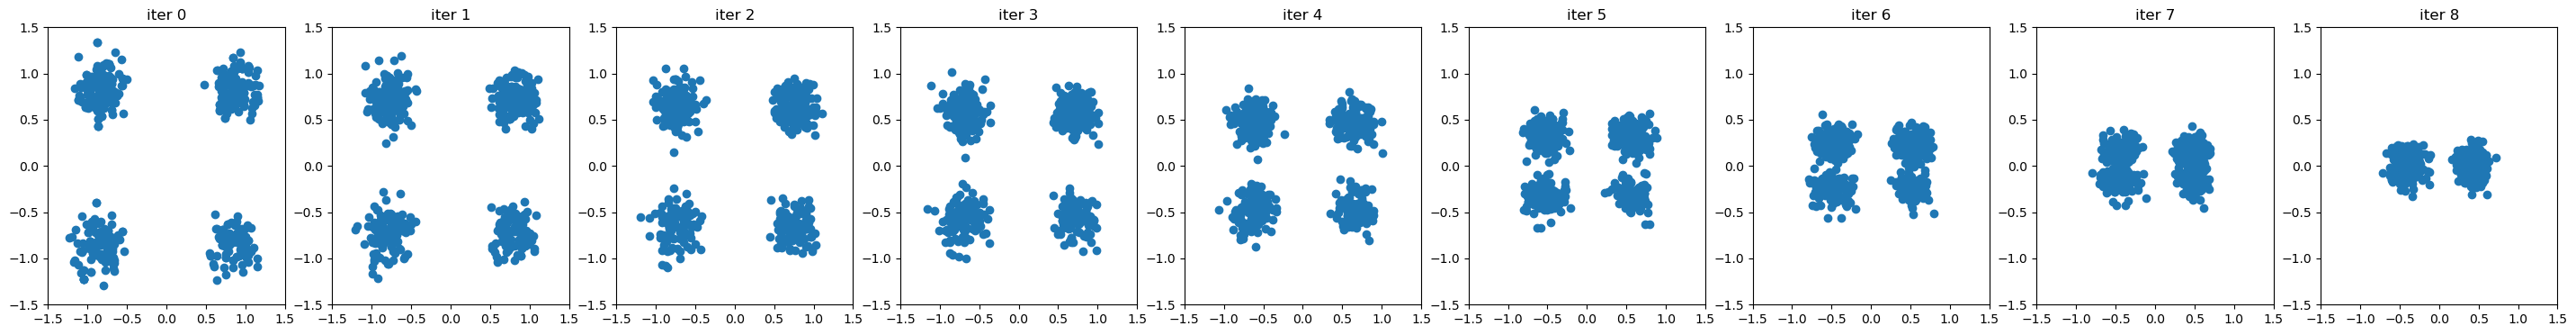

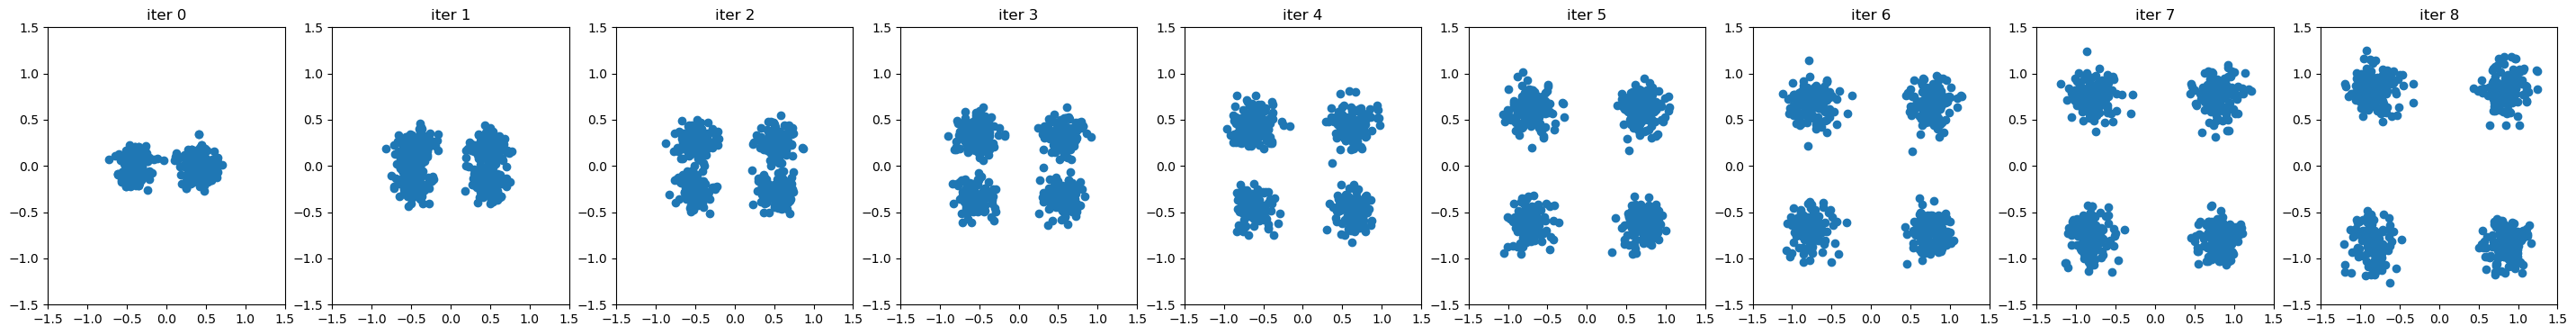

In [261]:
x_0 = p0_buffer.sample(512)
with torch.no_grad():
    fwd_trajectory = sample_trajectory(fwd_model, x_0, "forward", gamma, n_steps, t_max)
_ = plot_trajectory(fwd_trajectory, indices=[0, 3, 5, 7, 10, -7, -5, -3, -1])


x_1 = p1_buffer.sample(512)
with torch.no_grad():
    bwd_trajectory = sample_trajectory(bwd_model, x_1, "backward", 
                                       gamma, n_steps, t_max)
_ = plot_trajectory(bwd_trajectory, indices=[0, 3, 5, 7, 10, -7, -5, -3, -1])